In [4]:
using CairoMakie, Random, LinearAlgebra, Dates


# convenience variables for indexing
const infra = 1
const supra = 3



function csim(d,sigma)
    #return max.(1-abs(d),-0)
    return exp(-0.5*(d/sigma)^2)#/(sigma*sqrt(2*pi))
end

# Connection strength function
function LaminarSpread(receiver::Float64, sender::Float64)
    M = zeros(3,3)
    amp = 0.005
    M[infra,supra] = amp * (1 - max(receiver - sender,0))
    M[supra,infra] = amp * (1 - max(sender - receiver,0))
    return M
end



toshow = [1 10 20 30]
function TauPropagation(Ctx,Ctype,Ncortices,toshow,W)
    hmaps = []
    trends = []
    trendinfras = []
    trendsupras = []
    densities = []
    cmax = 0.0
    dmax = 0.0
    t = 0
    for i = 1:toshow[end]
        #global t, cmax, dmax, hmaps, trends, trendinfras, trendsupras, densities

        if i in toshow
            t = t + 1
            cmax = max(maximum(Ctx),cmax)

            push!(hmaps, deepcopy(Ctx'))

            trend = Ctx[3,:] ./ (Ctx[1,:] .+ Ctx[3,:] .+ 0.001)
            trendinfra = Ctx[infra,:]
            trendsupra = Ctx[supra,:]

            push!(trends,trend)
            push!(trendinfras,trendinfra)
            push!(trendsupras,trendsupra)
            density = Ctx[3,:] .+ Ctx[1,:]
            dmax = max(maximum(density),dmax)
            push!(densities,density)
        end

        # Spread of tau per time step
        for r = 1:Ncortices
            for s = 1:Ncortices
                if s!=r
                    #Ctx[:,r] = Ctx[:,r] .+ 0.4.*(1.0 .- Ctx[:,r]) .* (W(Ctype[r],Ctype[s])*Ctx[:,s])

                    Ctx[:,r] = Ctx[:,r] .+   (W(Ctype[r],Ctype[s]) * Ctx[:,s] ) # linear growth of tau
                
                    Ctx .= min.(Ctx,1) #upper threshold
                    Ctx .= max.(Ctx,0) #lower threshold
                end
            end
        end
    end
    return hmaps,trends, trendinfras, trendsupras, densities, cmax, dmax

end


function BigPlot(hmaps,trends, trendinfras, trendsupras, densities, cmax, dmax; linfit = true, savefig = false, filename = "CTE")

    fig = Figure(size = (1200, 1000), fonts = (; regular = "Arial"))

    for t in 1:length(toshow)
        #global cmax, dmax, hmaps, trends, densities

        ax = Axis(fig[1, t], yticks = (1:3, ["L5/6", "L4", "L2/3"]))
        heatmap!(ax, Ctype, LinRange(1,3,3), hmaps[t], colormap = :heat, colorrange=(0.0,cmax))

        if t==1
            ax2 = Axis(fig[2, t], ylabel = "SGI")
        else
            ax2 = Axis(fig[2, t])

            # Add a column of ones for the intercept term

        end

        lines!(ax2, Ctype,0.5 .* ones(Ncortices),linestyle = :dot, color = :gray)
        scatterlines!(ax2,Ctype,trends[t], linewidth = 2)

        if t != 1 & linfit 
            X = hcat(ones(length(Ctype)), Ctype)

            # Solve for coefficients [intercept, slope]
            coefficients = X \trends[t]
            #println(coefficients[1])
            slope =  round(coefficients[2], sigdigits=2)
            lines!(ax2, Ctype,coefficients[2].*Ctype .+ coefficients[1], linewidth = 2, linestyle = :dash, color = :red, label = "slope = $slope")
            axislegend(position = :rb)
        end

        ylims!(ax2,-0.1,1.1)
        xlims!(ax2,-0.1,maximum(Ctype) + 0.1)
        if t==1
            ax3 = Axis(fig[3, t], xlabel = "Degree of lamination", ylabel = "Density (a.u.)")

        else
            ax3 = Axis(fig[3, t], xlabel = "Degree of lamination")
        end

        scatterlines!(ax3,Ctype, trendinfras[t], label = "infragranular")
        scatterlines!(ax3,Ctype, trendsupras[t], label = "supragranular")
        scatterlines!(ax3,Ctype, densities[t], linestyle = :dot, label = "total")

        ylims!(ax3,-0.05,1.1*dmax)

        if t==1
            axislegend()
        end

        ax.title = "A-" * string(t)
        ax2.title = "B-" * string(t)
        ax3.title = "C-" * string(t)
        end



    mx = maximum(Ctx)
    cb = Colorbar(fig[1, 5]; colorrange=(0.0,cmax), label = "Proportion of tau", colormap = :heat)
   
    if savefig
        datestring = Dates.format(now(), "yyyy-mm-dd-T_HHMM")
        save(filename*datestring*".png", fig; pt_per_unit=1)
        save(filename*datestring*".eps", fig; pt_per_unit=1)
    end
    return fig
end





BigPlot (generic function with 1 method)

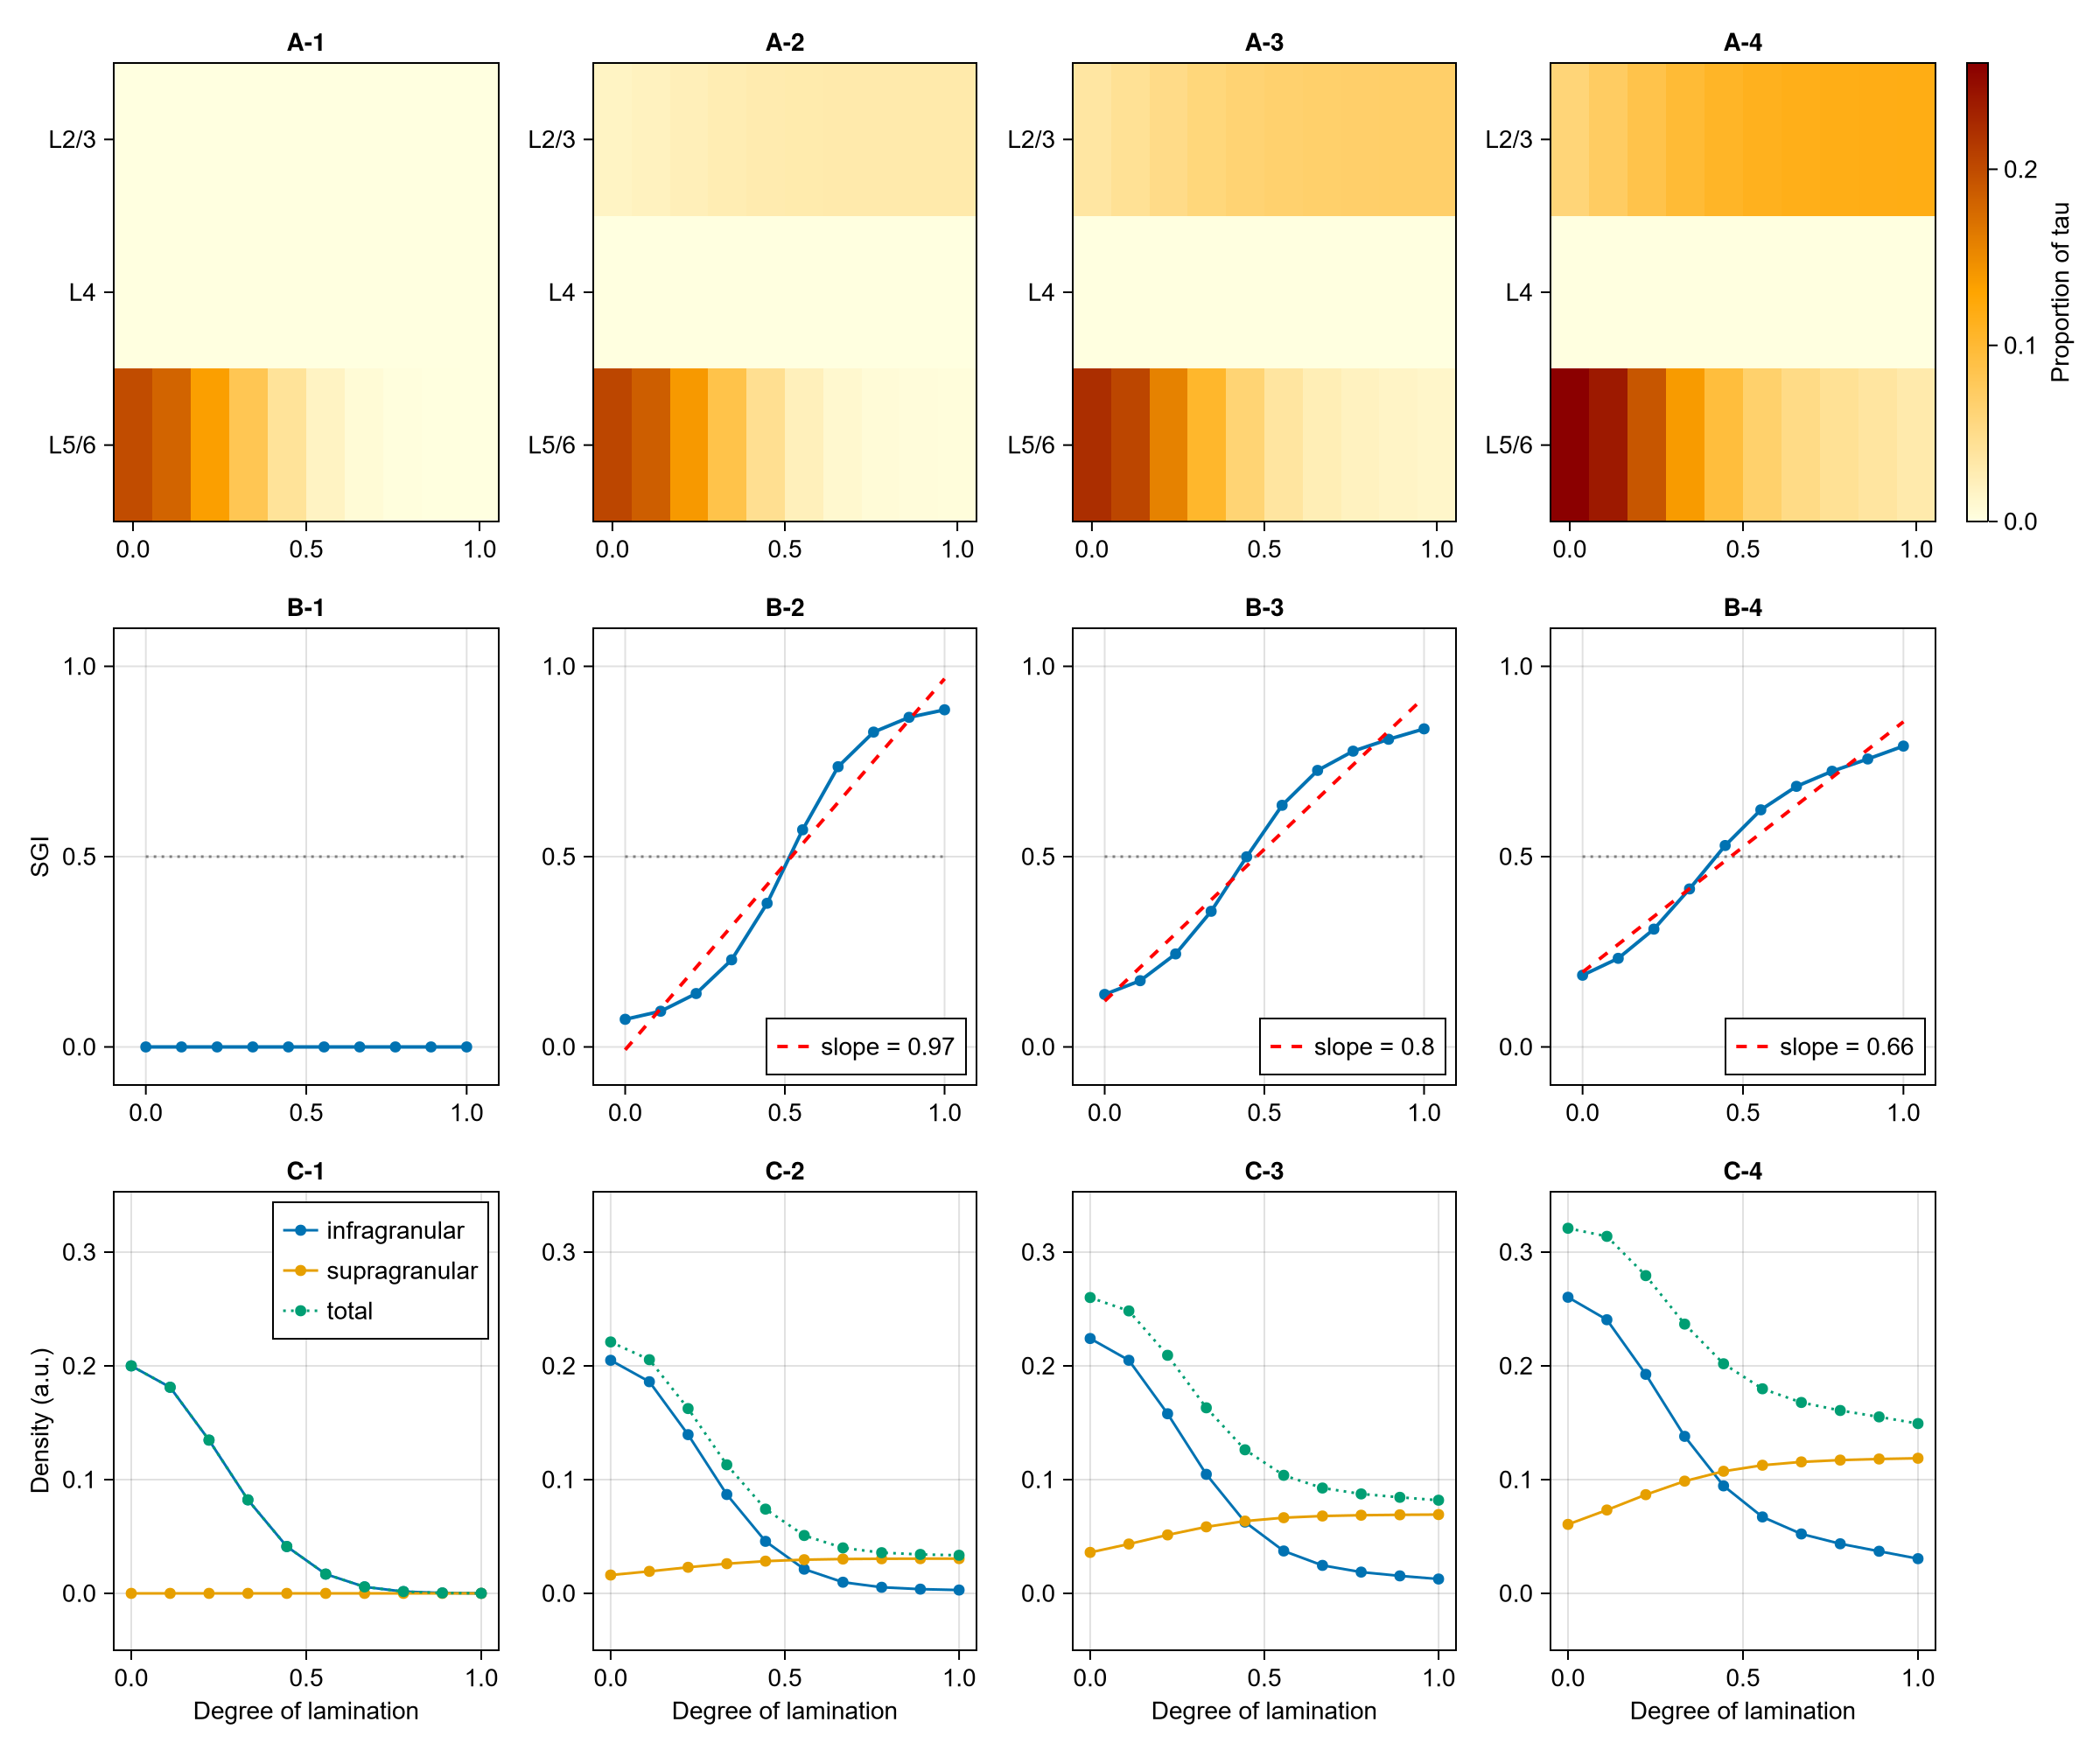

In [5]:
Ncortices = 10
Ctype = LinRange(0,1,Ncortices)

Ctx = zeros(3,Ncortices)


# Initial tau distribution

Ctx[infra,:] .= 0.2 .* exp.(-0.5 .* ((Ctype .- 0.0) ./ 0.25 ) .^2)

hmaps,trends, trendinfras, trendsupras, densities, cmax, dmax = TauPropagation(Ctx,Ctype,Ncortices,toshow,LaminarSpread)

fig = BigPlot(hmaps,trends, trendinfras, trendsupras, densities, cmax, dmax, savefig = false)
fig
